<a href="https://colab.research.google.com/github/ArmandoLp/AprendizajeMaquina-Profundo/blob/main/Tarea2-Prediccion%20de%20edades%20con%20base%20en%20fotos%20de%20rostros-completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-summary

## 1. Predicción de edades
En este ejercicio debes entrenar modelos de regresión para predecir edades en el conjunto de
datos UTKFace. La solución debe cumplir con los siguientes puntos:


*   Implementar la tubería de datos usando el conjunto de rostros alineados y recortados2
*   Agregar acrecentamiento de datos usando un espejeo horizontal.
*   Particionar aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %.
*   Usando transferencia de conocimiento, entrenar un modelo reentrenando solo la última capa.
*   Usando transferencia de conocimiento, entrenar un modelo reentrenando toda la red.
*   Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

In [ ]:

# marcas de tiempo
import datetime
# explorar el sistema de archivos
import glob
# sistema de archivos
import os
# funciones aleatorias
import random
# marcas de tiempo
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
# leer archivo matlab
from scipy.io import loadmat
# cargador de datos
from torch.utils.data import DataLoader
# trazas de Tensorboard
from torch.utils.tensorboard import SummaryWriter
# inspección de arquitectura
from torchsummary import summary
# barra de progreso
from tqdm import trange
# imágenes
from PIL import Image


# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 16
# tamaño de la imagen
IMG_SIZE = 80

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 4

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)

    display_grid(x, titles, rows, cols, figsize)

def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)

### 1.1 Tubería de datos
Basándonos en la tubería utilizada con mnist generamos la propia
![arquitectura](https://github.com/gibranfp/CursoAprendizajeProfundo/raw/2e039bffa4020aa81eb51f36cde0bf22d974acb4/figs/mlp_datos.png)

In [ ]:
class UTKFace:

    def __init__(self, root, 
                 transform=None, download=False):
     
        # guardamos atributos
        self.root = join(root, 'UTKFace')
        self.transform = transform

        # creamos directorio raíz
        os.makedirs(self.root, exist_ok=True)

        # descargados datos
        if download:
            self.download()

        '''
        # cargamos partición y subconjunto
        mat = loadmat(join(self.root, 'datasplits.mat'))
        self.x = mat[f'{subset}{split}'][0]

        # leemos las clases y sus números de ejemplos
        df = pd.read_csv(join(self.root, 'classes.csv'))

        # guardamos etiquetas como int
        y = [np.repeat(i, n) for i, n 
             in enumerate(df['examples'])]
        self.y = np.concatenate(y)
        '''
        self.y=[]
        self.images_name=[]
        self.length=0

        for img_filename in os.listdir(self.root+'/UTKFace/'):
          if img_filename.endswith(".jpg"):
            age = int(img_filename.split('.')[0].split('_')[0])
            self.y.append(age)
            self.length += 1
            self.images_name.append(img_filename)
  

    def __getitem__(self, i):
        # cargamos la imagen
        #x = self.x[i]
        img=self.images_name[i]
        path = join(self.root+'/UTKFace/' , img)
        imagen = Image.open(path)

        # aplicamos transformación
        if self.transform is not None:
            imagen = self.transform(imagen)
        # leemos la etiqueta como int
        y =  int(img.split('.')[0].split('_')[0])
        # leemos la etiqueta como str
        #label = self.labels[y]
        # regresamos ejemplo como dict
        return {'x': imagen, 'y': y}

    def __len__(self):
        # regresamos numeros de ejemplos
        return self.length

    def download(self):
      tvu.download_and_extract_archive(
              url='http://cloud.xibalba.com.mx/s/sNcxdr2o7aeM7yF/download',
              download_root=self.root,
              filename='UTKFace.tar.gz',
          )

In [ ]:
!cp -r UTKFace/ ../data/UTKFace/

In [ ]:
#creamos el dataset
ds= UTKFace(DATA_DIR, download=False)
#ds=UTKFace('./content/', download=False)

In [ ]:
#¿cuántos ejemplos tenemos?
len(ds)

23708

Imagen dimensiones=(200, 200) tipo=<class 'PIL.JpegImagePlugin.JpegImageFile'>
Etiqueta=  50


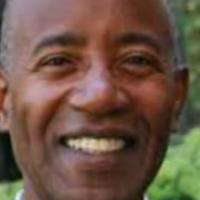

In [ ]:
#visualizamos un ejemplo aleatorio
example = ds[21]
x, y = example['x'], example['y']
print(f'Imagen dimensiones={x.size} tipo={type(x)}')
print('Etiqueta= ', y)
example['x']

### 1.3 Transformaciones
Para esta parte se pide realizar un espejeo horizontal, para que sea más eficiente lo definiremos como una transformación que utilizará el cosntructor del dataset, de esta manera no creamos ejemplos que gasten más memoria, mas que cuando los necesita

In [ ]:
espejeo=T.Compose([T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(mean=IMAGENET_MEAN, std= IMAGENET_STD)])

### 1.4 PArticion train-test
Se particiona aleatoriamente 80% para entrenamiento

In [ ]:
data_espejeado= UTKFace(root= DATA_DIR,transform=espejeo)
trn_ds, val_ds = torch.utils.data.random_split(data_espejeado, [int(.8*len(data_espejeado)), len(ds) - int(.8*len(data_espejeado))])

In [ ]:
print(len(val_ds), len(trn_ds))

4742 18966


Definimos el dataloader y visualizamos algunos ejemplos con su edad

x shape=torch.Size([16, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([16]) dtype=torch.int64


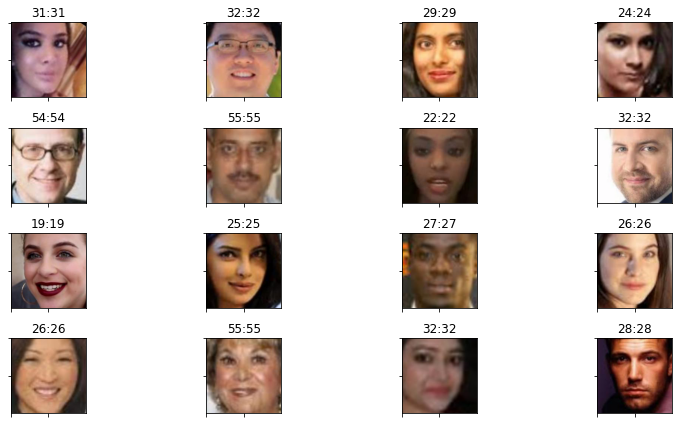

In [ ]:
trn_dl=DataLoader(
    trn_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers= 4,
)
# desplegamos lote
batch = next(iter(trn_dl))
x, y = batch['x'] , batch['y']
titles = [f'{v}:{l}' for v, l in zip(y, y)]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

x shape=torch.Size([16, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([16]) dtype=torch.int64


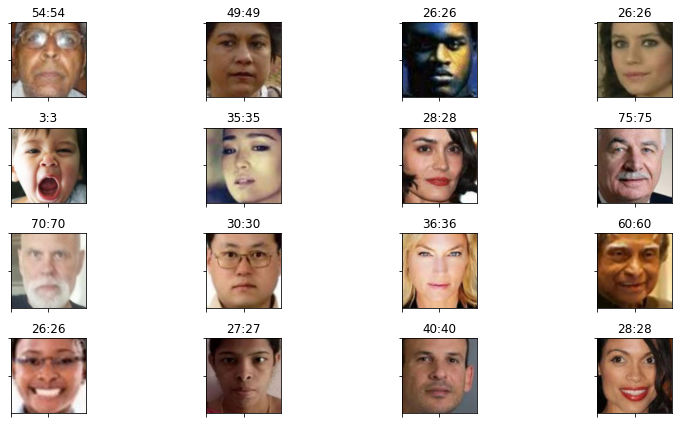

In [ ]:
val_dl=DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers= 4,
)
# desplegamos lote
batch = next(iter(trn_dl))
x, y = batch['x'] , batch['y']
titles = [f'{v}:{l}' for v, l in zip(y, y)]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

### 1.4 El modelo
en esta sección utilizaremos la red shufflenet pre entrenada para sólo agregar una capa lineal a la salida que recibe 1024 atributos y lo mapea a una sola neurona que nos va a dar la edad
Para esta primera parte utilizaremos transfer learning

In [ ]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

Congelamos los parámetros para el transfer learning, de esta manera sólo entrenamos nuestra capa lineal

In [ ]:
# congelamos los parámetros
for param in model.parameters():
    param.requires_grad = False
# congelamos las estadísticas
model.eval()

# remplazo de última capa
model.fc = nn.Linear(1024, 1)


Probamos la salida de la red, esto para verificar que las dimensiones esten bien y ver si necesita un reshape o squeeze (como es el caso)

In [ ]:
entrada=torch.zeros(1,3,80,80)
salida=model(entrada)
print(salida.shape)

torch.Size([1, 1])


In [ ]:
def train_epoch(dl, model, opt):
    """Entrena una época"""
    # entrenamiento de una época
    for batch in dl:
        x = batch['x']
        y_true = batch['y']
       
        #y_true = y_true.squeeze(0)
        y_true= y_true.float()
        # computamos logits
        y_lgts = model(x)
        y_lgts = y_lgts.squeeze()
        # computamos la pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch['x']
            y_true = batch['y']
            y_true = y_true.squeeze(0)
            y_true= y_true.float()
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            y_lgts = y_lgts.squeeze()
            # computamos las probabilidades
            #y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            #y_pred = torch.argmax(y_prob, 1)
            
            # computamos la pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # computamos la exactitud
            #acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            #accs.append(acc.item())

        loss = np.mean(losses) * 100
        #acc = np.mean(accs) * 100
        
        return loss#, acc

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights.pth')
    )

def train(model, trn_dl, val_dl,
          trn_writer, val_writer, epochs,
          trn_batches=None, val_batches=None):

    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-3)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

   
   
   
    # ciclo de entrenamiento
    #best_acc = 999999999
    best_loss=999999
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        #trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        trn_loss = eval_epoch(trn_dl, model, trn_batches)
        # registramos trazas de TB 
        trn_writer.add_scalar('metrics/loss', trn_loss, epoch)
        #trn_writer.add_scalar('metrics/acc', trn_acc, epoch)

        # evaluamos la época en validación
        #val_loss, val_acc = eval_epoch(val_dl, model, val_batches)
        val_loss = eval_epoch(val_dl, model, val_batches)
        # registramos trazas de TB
        val_writer.add_scalar('metrics/loss', val_loss, epoch)
        #val_writer.add_scalar('metrics/acc', val_acc, epoch)

        # si hay mejora guardar punto de control
        
        if val_loss < best_loss:
          best_loss=val_loss
          save_check_point(model, epoch, run_dir)

In [ ]:

# directorio de la corrida
run_dir = join('runs', 'UTKFace', timestamp())
run_dir

'runs/UTKFace/210116T103605'

In [ ]:

# escritor de trazas
trn_writer = SummaryWriter(join(run_dir, 'trn'))
val_writer = SummaryWriter(join(run_dir, 'val'))

In [ ]:

# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/UTKFace/210116T103605:
trn  val

runs/UTKFace/210116T103605/trn:
events.out.tfevents.1610793365.011cd60757c8.62.6

runs/UTKFace/210116T103605/val:
events.out.tfevents.1610793365.011cd60757c8.62.7


### 1.5 Entrenamiento
Realizamos el entrenamiento en gpu (en realidad no está en gpu, era por esto que tardaba bastante :'v no estaba en gpu, porque seleccioné la gpu pero jamás moví el modelo ni los parámetros :'vvvvvv)
Este modelo al ser regresión no entrena con accuracy, sólo nos fijaremos en el valor de pérdida para guardar el mejor modelo, como se define en save_checkpoint
![aiuda](https://i.pinimg.com/736x/fa/83/bd/fa83bd919590c48fe670453e331ee3de.jpg)

In [ ]:
# entrenamos modelo
gpu = True
device = "cpu"
if gpu:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Use device:', device)

train(model, trn_dl, val_dl, trn_writer, val_writer, 
      epochs=10, trn_batches=16, val_batches=16)






  0%|          | 0/10 [00:00<?, ?it/s]

Use device: cuda







 10%|█         | 1/10 [02:35<23:17, 155.28s/it]




 20%|██        | 2/10 [05:06<20:32, 154.08s/it]




 30%|███       | 3/10 [07:37<17:52, 153.24s/it]




 40%|████      | 4/10 [10:08<15:14, 152.40s/it]




 50%|█████     | 5/10 [12:40<12:41, 152.22s/it]




 60%|██████    | 6/10 [15:10<10:06, 151.69s/it]




 70%|███████   | 7/10 [17:39<07:32, 150.97s/it]




 80%|████████  | 8/10 [20:07<04:59, 149.93s/it]




 90%|█████████ | 9/10 [22:34<02:29, 149.17s/it]




100%|██████████| 10/10 [25:02<00:00, 150.22s/it]


In [ ]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}


runs/UTKFace/210116T103605:
trn  val  weights.pth

runs/UTKFace/210116T103605/trn:
events.out.tfevents.1610793365.011cd60757c8.62.6

runs/UTKFace/210116T103605/val:
events.out.tfevents.1610793365.011cd60757c8.62.7


Verificamos cual fue la mejor época y seleccionamos los pesos que se guardaron

In [ ]:

# cargamos el punto de contral
ckpt = torch.load(join(run_dir, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 8


### 1.6 Verificación de resultados de la red con transfer-learning

In [ ]:
# instanciamos un modelo vacio
model = tvm.shufflenet_v2_x0_5()
model.fc = nn.Linear(1024, 1)

# cargamos pesos
state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

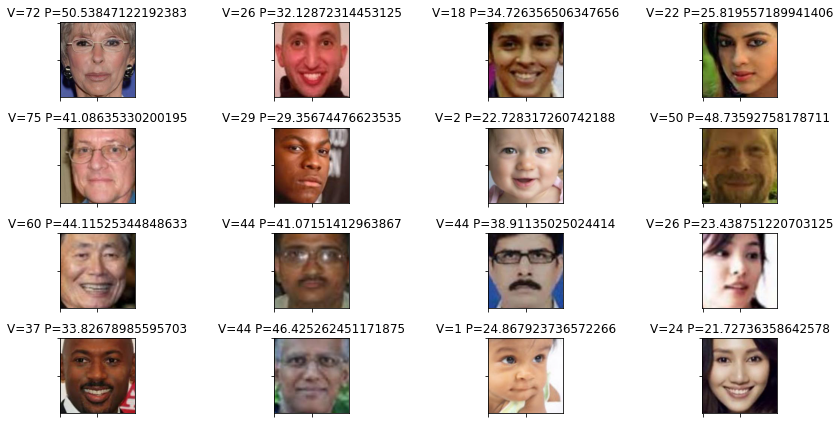

In [ ]:
with torch.no_grad():
    batch = next(iter(val_dl))
    x, y_true = batch['x'], batch['y']
    #y_pred = torch.argmax(F.softmax(model(x), 1), 1)
    y_pred=model(x).squeeze()
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

Como podemos ver, no está muy distante de la edad real, sin embargo tenemos un problema con la cara de bebés, veamos que pasa con toda la red.
Ahora entrenamos toda la red

Descongelamos los parámetros para la red

In [ ]:
# congelado de parámetros de la CNN
for param in model.parameters():
    param.requires_grad = True
# congelado de estadísticas de todo el modelo
_ = model.train()

### 1.6 Entrenamiento de la red completa, ahora si en GPU
![ahorasixd](https://i.pinimg.com/originals/01/6c/16/016c16459a08ed9194c57836d41368d8.jpg)

In [ ]:
model = model.to(device)
next(model.parameters()).device



device(type='cuda', index=0)

Definimos las funciones para la red para mover los parámetros 

In [ ]:
def train_epoch(dl, model, opt):
    """Entrena una época"""
    # entrenamiento de una época
    for batch in dl:
        x = batch['x']
        x=x.to(device)
        y_true = batch['y']
        y_true=y_true.to(device)
        #y_true = y_true.squeeze(0)
        y_true= y_true.float()
        # computamos logits
        y_lgts = model(x)
        y_lgts = y_lgts.squeeze()
      
        # computamos la pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch['x']
            x=x.to(device)
            y_true = batch['y']
            y_true=y_true.to(device)
            #y_true = y_true.squeeze(0)
            y_true= y_true.float()
            # computamos logits
            y_lgts = model(x)
            y_lgts = y_lgts.squeeze()

            #x = batch['x']
            #y_true = batch['y']
            #y_true = y_true.squeeze(0)
            #y_true= y_true.float()
            # hacemos inferencia para obtener los logits
            #y_lgts = model(x)
            #y_lgts = y_lgts.squeeze()
            # computamos las probabilidades
            #y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            #y_pred = torch.argmax(y_prob, 1)
            
            # computamos la pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # computamos la exactitud
            #acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            #accs.append(acc.item())

        loss = np.mean(losses) * 100
        #acc = np.mean(accs) * 100
        
        return loss#, acc

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights_all.pth')
    )

def train(model, trn_dl, val_dl,
          trn_writer, val_writer, epochs,
          trn_batches=None, val_batches=None):

    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-3)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

   
   
   
    # ciclo de entrenamiento
    #best_acc = 999999999
    best_loss=999999
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        #trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        trn_loss = eval_epoch(trn_dl, model, trn_batches)
        # registramos trazas de TB 
        trn_writer.add_scalar('metrics/loss', trn_loss, epoch)
        #trn_writer.add_scalar('metrics/acc', trn_acc, epoch)

        # evaluamos la época en validación
        #val_loss, val_acc = eval_epoch(val_dl, model, val_batches)
        val_loss = eval_epoch(val_dl, model, val_batches)
        # registramos trazas de TB
        val_writer.add_scalar('metrics/loss', val_loss, epoch)
        #val_writer.add_scalar('metrics/acc', val_acc, epoch)

        # si hay mejora guardar punto de control
        
        if val_loss < best_loss:
          best_loss=val_loss
          save_check_point(model, epoch, run_dir)
          save_check_point(model, epoch, run_dir)

In [ ]:
train(model, trn_dl, val_dl, trn_writer, val_writer, 
      epochs=10, trn_batches=16, val_batches=16)







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [01:17<11:41, 77.97s/it]





 20%|██        | 2/10 [02:34<10:20, 77.51s/it]





 30%|███       | 3/10 [03:50<08:58, 76.99s/it]





 40%|████      | 4/10 [05:04<07:37, 76.29s/it]





 50%|█████     | 5/10 [06:19<06:18, 75.74s/it]





 60%|██████    | 6/10 [07:33<05:00, 75.20s/it]





 70%|███████   | 7/10 [08:46<03:43, 74.66s/it]





 80%|████████  | 8/10 [10:00<02:28, 74.35s/it]





 90%|█████████ | 9/10 [11:14<01:14, 74.24s/it]





100%|██████████| 10/10 [12:27<00:00, 74.74s/it]


In [ ]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}


runs/UTKFace/210116T103605:
trn  val  weights_all.pth  weights.pth

runs/UTKFace/210116T103605/trn:
events.out.tfevents.1610793365.011cd60757c8.62.6

runs/UTKFace/210116T103605/val:
events.out.tfevents.1610793365.011cd60757c8.62.7


In [ ]:

# cargamos el punto de contral
ckpt = torch.load(join(run_dir, 'weights_all.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 8


In [ ]:
# instanciamos un modelo vacio
model = tvm.shufflenet_v2_x0_5()
model.fc = nn.Linear(1024, 1)

# cargamos pesos
state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

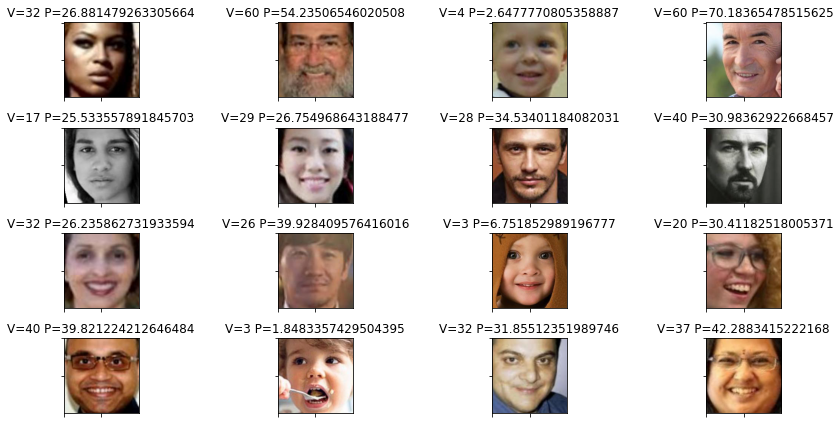

In [ ]:
with torch.no_grad():
    batch = next(iter(val_dl))
    x, y_true = batch['x'], batch['y']
    #y_pred = torch.argmax(F.softmax(model(x), 1), 1)
    y_pred=model(x).squeeze()
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

Ufas trufas, es mucho mejor :o

Como podemos ver, al entrenar toda la red, shuffle_net parte de pesos pre entrenados, por lo que con un par de épocas más es suficiente como para que mejore su desempeño en nuestra tarea, al haber aprendido caracteristicas "generales" para un conjunto diverso de imágenes, al desbloquear parámetros y entrenar con un tipo de imágenes "similar" adquiere la habilidad de identificar mejor estas caracteríscias.


Al final de cuentas, hice mal la parte de agregar una capa y usar transfer-learning, sin embargo, de haberlo hecho correctamente, el tiempo hubiese sido mucho más rápido, por lo que podemos comcluir un par de cosas.

Al usar transfer learning se aprovechan las caracteristicas aprendidas y entrenando la punta de la red podemos tener resultados increibles sin tener que entrenar miles de parámetros, lo cual tomaría muchísimo tiempo. 

Sin embargo, al usar una red pre entrenada y entrenarla para la tarea puede aprender mejor caracteristicas específicas de la tarea, sin embargo sería más lento. En este caso, resulta mucho mejor re-entrenar la red completa.